In [1]:
# ch4/ch4_2_rnn/lstm.ipynb
# 标准库
import sys

# 第三方库
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import plot_model

# 自定义模块
sys.path.append('./../../')
import utils.plot as p
import utils.metrics as m
import utils.dataset as d

# 绘图参数
name_model = 'LSTM'
name_var = '阵风风速'
name_unit = ' (km/h)'
p.set_matplotlib(plot_dpi=80, save_dpi=600, font_size=12)


,序列长度,最大值,最小值,均值,标准差,偏度,峰度
0,744,92.34,3.24,29.82,15.1,0.71,0.78


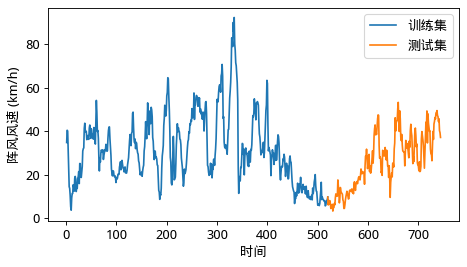

train.shape=(515, 6), test.shape=(224, 6)
train_x.shape=(515, 5), train_y.shape=(515, 1)
test_x.shape=(224, 5), test_y.shape=(224, 1)
train_x_n.shape=(515, 5), train_y_n.shape=(515, 1)
test_x_n.shape=(224, 5), test_y_n.shape=(224, 1)
train_x_n.shape=(515, 5, 1), train_y_n.shape=(515, 1)
test_x_n.shape=(224, 5, 1), test_y_n.shape=(224, 1)


In [2]:
# 数据读取和统计分析
data = pd.read_csv('./data/data_wind_speed.csv')
series = data['WindGustSpeed (Kilometres per hour)'].values[:, np.newaxis]
ratio_train = 0.7  # 训练样本比例
num_train = int(len(series)*ratio_train)  # 训练样本数量
d.stats(series)
p.plot_dataset(
    train=series[0:num_train],
    test=series[num_train:],
    xlabel='时间',
    ylabel=f'{name_var}{name_unit}',
    fig_name=f'{name_model}_序列'
)

# 监督学习样本构建
H = 5
S = 1
D = 1
train = d.series_to_supervised(series[0:num_train], H, S)  # [num_train, H+1]
test = d.series_to_supervised(series[num_train-H:], H, S)  # [num_test, H+1]
print(f"{train.shape=}, {test.shape=}")

# 训练测试样本划分
train_x = train.iloc[:, :-1].values  # [num_train, H]
train_y = train.iloc[:, -1].values[:, np.newaxis]  # [num_train, 1]
test_x = test.iloc[:, :-1].values  # [num_test, H]
test_y = test.iloc[:, -1].values[:, np.newaxis]  # [num_test, 1]
print(f'{train_x.shape=}, {train_y.shape=}')
print(f'{test_x.shape=}, {test_y.shape=}')

# 样本归一化
x_scalar = MinMaxScaler(feature_range=(0, 1))
y_scalar = MinMaxScaler(feature_range=(0, 1))
train_x_n = x_scalar.fit_transform(train_x)  # [num_train, H]
test_x_n = x_scalar.transform(test_x)  # [num_test, H]
train_y_n = y_scalar.fit_transform(train_y)  # [num_train, 1]
test_y_n = y_scalar.transform(test_y)  # [num_test, 1]
print(f'{train_x_n.shape=}, {train_y_n.shape=}')
print(f'{test_x_n.shape=}, {test_y_n.shape=}')

# 数据重构
train_x_n = train_x_n.reshape(
    train_x_n.shape[0],
    train_x_n.shape[1],
    D)  # [num_train, H] -> [num_train, H, D], D = 1
test_x_n = test_x_n.reshape(
    test_x_n.shape[0],
    test_x_n.shape[1],
    D)  # [num_test, H] -> [num_test, H, D], D = 1
print(f'{train_x_n.shape=}, {train_y_n.shape=}')
print(f'{test_x_n.shape=}, {test_y_n.shape=}')


In [3]:
# 模型构建
model = Sequential()
model.add(LSTM(  # LSTM层
    32, 
    activation='tanh', 
    input_shape=(H, D),
    return_sequences=True))
model.add(LSTM(32, activation='tanh'))  # LSTM层
model.add(Dense(32, activation='relu'))  # Dense层
model.add(Dense(1, activation='linear'))  # 输出层

# 模型编译
model.compile(  # 使用字符串初始化
    optimizer='rmsprop', 
    loss='mse'
)

# 训练集-训练
history = model.fit(
    train_x_n,  # 训练集特征
    train_y_n,  # 训练集标签
    epochs=100,  # 迭代次数
    batch_size=16,  # Mini-Batch
    verbose=0,   # 不显示过程
    shuffle=False,  # 不打乱样本
)

# 模型查看
plot_model(
    model, 
    to_file=f'./fig/{name_model}_模型结构.jpg',
    show_shapes=True,  # 显示数据维度/形状
    show_dtype=True,  # 显示数据类型
    dpi=600
)

# 测试集-预测
y_hat_n = model.predict(
    test_x_n,  # 测试集特征
    verbose=0  # 不显示过程
)
y_hat = y_scalar.inverse_transform(y_hat_n)  # [num_test, 1]

# 测试集-误差计算
m.all_metrics(y_true=test_y, y_pred=y_hat)


2022-12-03 17:30:16.365757: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-03 17:30:16.372664: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-03 17:30:16.373179: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-03 17:30:16.374039: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

mse=26.941
rmse=5.191
mae=3.863
mape=16.562%
sde=4.514
r2=0.833
pcc=0.936


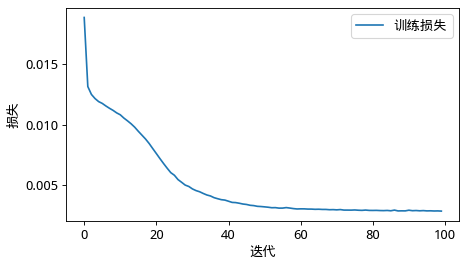

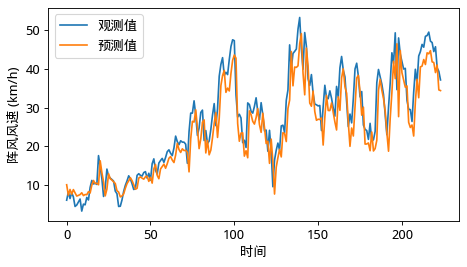

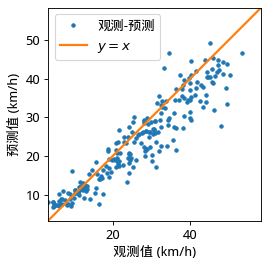

In [4]:
# 可视化
p.plot_losses(
    train_loss=history.history['loss'],
    xlabel='迭代',
    ylabel='损失',
    fig_name=f'{name_model}_损失'
)
p.plot_results(
    y_true=test_y,
    y_pred=y_hat,
    xlabel='时间',
    ylabel=f'{name_var}{name_unit}',
    fig_name=f'{name_model}_预测曲线'
)
p.plot_parity(
    y_true=test_y,
    y_pred=y_hat,
    xlabel=f'观测值{name_unit}',
    ylabel=f'预测值{name_unit}',
    fig_name=f'{name_model}_Parity'
)
